In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import random
from typing import Callable
import pandas as pd
from timm.layers import DropPath, trunc_normal_
import torch.optim as optim  # For optimizers
from torch.optim.lr_scheduler import ReduceLROnPlateau  # For learning rate scheduler

In [ ]:
# Configuration
DATASET_PATH = "data"
ANNOTATIONS_FILE = os.path.join(DATASET_PATH, "annotations.json")
IMAGES_DIR = os.path.join(DATASET_PATH)
INPUT_SHAPE = (384, 384)
BATCH_SIZE = 4
EPOCHS = 20
LEARNING_RATE = 1e-4
NUM_WORKERS = 0  
METADATA_FILE = os.path.join(DATASET_PATH, "metadata_splits.csv")

VOC_CLASSES = [
    "background",
    "turtle_head",
    "turtle_carapace",
    "turtle_flipper",
]

NUM_CLASSES = len(VOC_CLASSES)

# Create necessary directories
os.makedirs('checkpoints', exist_ok=True)
os.makedirs('results', exist_ok=True)

class TurtleSegDataset(Dataset):
    def __init__(self, image_paths, coco, transform=None):
        super().__init__()
        self.image_paths = image_paths
        self.coco = coco
        self.transform = transform
        self.catIds = coco.getCatIds()
        
        print("Pre-computing masks...")
        self.masks = {}
        self.class_counts = {i: np.int64(0) for i in range(NUM_CLASSES)}
        
        for img_name in tqdm(image_paths, desc="Preprocessing"):
            img_id_list = [img['id'] for img in coco.dataset['images'] 
                          if img['file_name'] == img_name]
            if not img_id_list:
                continue
                
            img_id = img_id_list[0]
            img_info = coco.loadImgs([img_id])[0]
            height, width = img_info['height'], img_info['width']
            
            mask = np.zeros((height, width), dtype=np.uint8)
            ann_ids = coco.getAnnIds(imgIds=img_id, catIds=self.catIds)
            anns = coco.loadAnns(ann_ids)
            
            category_order = [3, 2, 1]
            for cat_id in category_order:
                for ann in anns:
                    if ann['category_id'] == cat_id:
                        single_mask = coco.annToMask(ann)
                        mask = np.where((single_mask == 1) & (mask == 0), 
                                      cat_id, mask)
            
            self.masks[img_name] = mask
            
            for class_id in range(NUM_CLASSES):
                self.class_counts[class_id] += np.sum(mask == class_id)
        
        total = sum(self.class_counts.values())
        weights = {k: total / (v + 1e-8) for k, v in self.class_counts.items()}
        max_weight = max(weights.values())
        self.class_weights = {k: v / max_weight for k, v in weights.items()}
        print("Class weights:", self.class_weights)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        
        image = cv2.imread(os.path.join(IMAGES_DIR, img_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = self.masks[img_name].copy()
        
        if image.shape[0] > image.shape[1]:
            image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
            mask = cv2.rotate(mask, cv2.ROTATE_90_CLOCKWISE)
        
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].long()
        
        return image, mask

def get_training_augmentation():
    return A.Compose([
        A.RandomResizedCrop(
            height=INPUT_SHAPE[0],
            width=INPUT_SHAPE[1],
            scale=(0.8, 1.0)
        ),
        A.Compose([
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(
                shift_limit=0.2,
                scale_limit=0.2,
                rotate_limit=30,
                p=0.5
            ),
            A.OneOf([
                A.RandomBrightnessContrast(
                    brightness_limit=0.2,
                    contrast_limit=0.2,
                    p=0.5
                ),
                A.RandomGamma(gamma_limit=(80, 120), p=0.5),
            ], p=0.3),
            A.OneOf([
                A.GaussNoise(var_limit=(10.0, 50.0)),
                A.GaussianBlur(),
                A.MotionBlur(),
            ], p=0.2),
        ], p=0.8),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        ToTensorV2(),
    ])

def get_validation_augmentation():
    return A.Compose([
        A.Resize(
            height=INPUT_SHAPE[0],
            width=INPUT_SHAPE[1]
        ),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        ToTensorV2(),
    ])


class SegmentationLoss(nn.Module):
    def __init__(self, weights=None):
        super().__init__()
   
        if weights is not None:
            weights = weights.float()
        self.ce = nn.CrossEntropyLoss(weight=weights)
        self.dice = DiceLoss()
        
    def forward(self, inputs, targets):
        
        inputs = inputs.float()
        targets = targets.long() 
        return self.ce(inputs, targets) + self.dice(inputs, targets)

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth
    
    def forward(self, inputs, targets):
     
        inputs = inputs.float()
        targets = targets.long()
        
        inputs = F.softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=inputs.shape[1])
        targets_one_hot = targets_one_hot.permute(0, 3, 1, 2).float()
        
        intersection = (inputs * targets_one_hot).sum(dim=(2, 3))
        union = inputs.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3))
        
        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler=None,
    num_epochs=EPOCHS,
    device='cpu',
    patience=7
):
    best_iou = 0.0
    patience_counter = 0
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_mean_iou': [],
        'val_mean_iou': [],
        'train_class_iou': [],
        'val_class_iou': [],
        'best_epoch': 0
    }

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        batch_metrics = {i: [] for i in range(NUM_CLASSES)}

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for images, masks in pbar:
            images = images.to(device).float()
            masks = masks.to(device).long()
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            loss.backward()
            # Apply gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            # Optionally step the scheduler per batch if it's not ReduceLROnPlateau
            if scheduler is not None and not isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step()

            epoch_loss += loss.item()
            
            # Calculate batch metrics
            with torch.no_grad():
                preds = torch.argmax(outputs, dim=1)
                preds_np = preds.cpu().numpy()
                masks_np = masks.cpu().numpy()
                for class_id in range(NUM_CLASSES):
                    for pred, true in zip(preds_np, masks_np):
                        intersection = np.logical_and(pred == class_id, true == class_id).sum()
                        union = np.logical_or(pred == class_id, true == class_id).sum()
                        iou = intersection / (union + 1e-7)
                        batch_metrics[class_id].append(iou)
            
            # Update progress bar
            mean_ious = {VOC_CLASSES[i]: f'{np.mean(batch_metrics[i][-10:]):.3f}' 
                       for i in range(NUM_CLASSES)}
            current_lr = scheduler.get_last_lr()[0] if scheduler and hasattr(scheduler, 'get_last_lr') else optimizer.param_groups[0]['lr']
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'lr': f'{current_lr:.6f}',
                **mean_ious
            })

        # Calculate average training loss and IoUs
        train_loss = epoch_loss / len(train_loader)
        train_class_iou = [np.mean(batch_metrics[i]) for i in range(NUM_CLASSES)]
        train_mean_iou = np.mean(train_class_iou)

        # Validation phase
        val_metrics = evaluate_model(model, val_loader, criterion, device)
        val_loss = val_metrics['loss']
        val_class_iou = val_metrics['class_iou']
        val_mean_iou = val_metrics['mean_iou']
        
        # Step the scheduler per epoch if it's ReduceLROnPlateau
        if scheduler is not None and isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_loss)

        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_class_iou'].append(train_class_iou)
        history['val_class_iou'].append(val_class_iou)
        history['train_mean_iou'].append(train_mean_iou)
        history['val_mean_iou'].append(val_mean_iou)

        # Print epoch results
        print(f'\nEpoch {epoch + 1} Results:')
        print(f'Train Loss: {train_loss:.4f}')
        print(f'Val Loss: {val_loss:.4f}')
        print(f'Train Mean IoU: {train_mean_iou:.4f}')
        print(f'Val Mean IoU: {val_mean_iou:.4f}')
        print('\nPer-class IoU:')
        for i in range(NUM_CLASSES):
            print(f'{VOC_CLASSES[i]} - Train IoU: {train_class_iou[i]:.4f}, Val IoU: {val_class_iou[i]:.4f}')

        # Save best model
        if val_mean_iou > best_iou:
            best_iou = val_mean_iou
            history['best_epoch'] = epoch
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                'best_iou': best_iou,
            }, 'checkpoints/best_model.pth')
            patience_counter = 0
            print('Model saved!')
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print(f'\nEarly stopping triggered after {epoch + 1} epochs')
            break

        # Save visualization
        if (epoch + 1) % 5 == 0:
            visualize_predictions(model, val_loader, save_path=f'results/epoch_{epoch+1}.png', device=device)

    return model, history



class EfficientDecoder(nn.Module):
    """Decoder with upsampling and feature fusion."""
    def __init__(self, dims):
        super(EfficientDecoder, self).__init__()
        
        self.up1 = nn.ConvTranspose2d(dims[4], dims[3], kernel_size=4, stride=2, padding=1)
        self.fuse1 = FeatureFusionModule(dims[3], dims[3], dims[3])  # Correct dimensions for x4

        self.up2 = nn.ConvTranspose2d(dims[3], dims[2], kernel_size=4, stride=2, padding=1)
        self.fuse2 = FeatureFusionModule(dims[2], dims[2], dims[2])  # Correct dimensions for x3
        
        self.up3 = nn.ConvTranspose2d(dims[2], dims[1], kernel_size=4, stride=2, padding=1)
        self.final_conv = nn.Conv2d(dims[1], NUM_CLASSES, kernel_size=1)

    def forward(self, features):
        x1, x2, x3, x4, x5 = features
        # print(f"Decoder input shapes: x1: {x1.shape}, x2: {x2.shape}, x3: {x3.shape}, x4: {x4.shape}, x5: {x5.shape}")
        
        # First upsampling and fusion
        x = self.up1(x5)
        # print(f"After up1, x shape: {x.shape}")
        x = self.fuse1(x, x4)  # Fuse with x4
        # print(f"After fuse1, x shape: {x.shape}")
        
        # Second upsampling and fusion
        x = self.up2(x)
        # print(f"After up2, x shape: {x.shape}")
        x = self.fuse2(x, x3)  # Fuse with x3
        # print(f"After fuse2, x shape: {x.shape}")
        
        # Third upsampling
        x = self.up3(x)
        # print(f"After up3, x shape: {x.shape}")
        
        # Final classification layer
        x = self.final_conv(x)
        # print(f"After final_conv, x shape: {x.shape}")
        
        return F.interpolate(x, size=INPUT_SHAPE, mode='bilinear', align_corners=False)





class FeatureFusionModule(nn.Module):
    """Feature Fusion Module for combining features with flexible channel alignment."""
    def __init__(self, in_channels1, in_channels2, out_channels):
        super(FeatureFusionModule, self).__init__()
        
        # Align each input feature map to the target number of channels
        self.align1 = nn.Conv2d(in_channels1, out_channels, kernel_size=1)
        self.align2 = nn.Conv2d(in_channels2, out_channels, kernel_size=1)
        
        # Convolution layers after alignment
        self.conv1 = nn.Conv2d(out_channels * 2, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.attention = nn.Conv2d(out_channels, out_channels, kernel_size=1)

    def forward(self, x1, x2):
        # print(f"FeatureFusionModule input shapes: x1: {x1.shape}, x2: {x2.shape}")
        # Align channels of both input feature maps to `out_channels`
        x1_aligned = self.align1(x1)
        x2_aligned = self.align2(x2)
        # print(f"After alignment: x1_aligned: {x1_aligned.shape}, x2_aligned: {x2_aligned.shape}")
        
        # Concatenate along the channel dimension
        x = torch.cat([x1_aligned, x2_aligned], dim=1)
        # print(f"After concatenation: x shape: {x.shape}")
        
        # Apply convolutional layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        # print(f"After conv layers: x shape: {x.shape}")
        
        # Apply attention mechanism
        attention = torch.sigmoid(self.attention(x))
        # print(f"Attention shape: {attention.shape}")
        
        # **Add the return statement**
        return x * attention


def plot_metrics(history, voc_classes):
    epochs = range(len(history['train_loss']))
    
    # Figure setup
    plt.figure(figsize=(20, 5))

    # 1. Training and Validation Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss', color='blue')
    plt.plot(epochs, history['val_loss'], label='Validation Loss', color='orange', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Metrics')
    plt.legend()

    # 2. Validation Mean IoU
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['val_mean_iou'], label='Validation Mean IoU', color='orange', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Mean IoU')
    plt.title('Validation Metrics')
    plt.legend()

    # 3. Class-wise IoU
    plt.subplot(1, 3, 3)
    colors = ['blue', 'orange', 'green', 'red']  # Adjust colors as needed
    for idx, class_name in enumerate(voc_classes):
        plt.plot(epochs, history['class_iou'][class_name], label=class_name, color=colors[idx])
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.title('Class IoU Metrics')
    plt.legend()

    # Adjust layout and save figure
    plt.tight_layout()
    plt.savefig('results/training_metrics.png')
    plt.show()



class EfficientBackbone(nn.Module):
    def __init__(self, input_channels=3, dims=[16, 32, 64, 128, 256]):
        super(EfficientBackbone, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, dims[0], kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(dims[0]),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(dims[0], dims[1], kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(dims[1]),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(dims[1], dims[2], kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(dims[2]),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(dims[2], dims[3], kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(dims[3]),
            nn.ReLU(inplace=True)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(dims[3], dims[4], kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(dims[4]),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x1 = self.conv1(x)  # Output dims[0], H/2, W/2
        # print(f"x1 shape: {x1.shape}")
        x2 = self.conv2(x1) # Output dims[1], H/4, W/4
        # print(f"x2 shape: {x2.shape}")
        x3 = self.conv3(x2) # Output dims[2], H/8, W/8
        # print(f"x3 shape: {x3.shape}")
        x4 = self.conv4(x3) # Output dims[3], H/16, W/16
        # print(f"x4 shape: {x4.shape}")
        x5 = self.conv5(x4) # Output dims[4], H/32, W/32
        # print(f"x5 shape: {x5.shape}")
        return [x1, x2, x3, x4, x5]


class PPLiteSeg(nn.Module):
    def __init__(self, input_channels=3, dims=[16, 32, 64, 128, 256]):
        super(PPLiteSeg, self).__init__()
        self.backbone = EfficientBackbone(input_channels, dims)
        self.decoder = EfficientDecoder(dims)

    def forward(self, x):
        features = self.backbone(x)
        x = self.decoder(features)
        return x


def calculate_iou(preds, targets):
    preds = preds.long()
    targets = targets.long()
    intersection = torch.logical_and(preds, targets)
    union = torch.logical_or(preds, targets)
    iou = torch.sum(intersection.float()) / (torch.sum(union.float()) + 1e-10)
    return iou.item()

def visualize_prediction(model, image, mask, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image.unsqueeze(0).to(device)
        output = model(image_tensor)
        pred = torch.argmax(output, dim=1)[0].cpu().numpy()
        
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    

    image_np = image.permute(1, 2, 0).cpu().numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
    ax1.imshow(image_np)
    ax1.set_title('Input Image')
    ax1.axis('off')
    
    ax2.imshow(mask.cpu().numpy())
    ax2.set_title('Ground Truth')
    ax2.axis('off')

    ax3.imshow(pred)
    ax3.set_title('Prediction')
    ax3.axis('off')
    
    plt.tight_layout()
    plt.show()

def visualize_predictions(model, loader, num_samples=3, device='cpu', save_path=None):
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

    color_map = {
        0: [128, 0, 128],  # background - purple
        1: [255, 255, 0],  # head - yellow
        2: [0, 128, 0],    # Carapace - green
        3: [0, 0, 255]     # flipper - blue
    }

    with torch.no_grad():
        for idx, (images, masks) in enumerate(loader):
            if idx >= num_samples:
                break

            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)[0].cpu().numpy()

            # Prepare the original image for display and clip values for valid range
            image = images[0].cpu().numpy().transpose(1, 2, 0)
            image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1] for display
            image = np.clip(image, 0, 1)  # Clip to valid range for imshow

            # Generate colored masks
            true_mask = masks[0].cpu().numpy()
            true_mask_colored = np.zeros((*true_mask.shape, 3), dtype=np.float32)
            pred_mask_colored = np.zeros((*preds.shape, 3), dtype=np.float32)

            for class_id, color in color_map.items():
                true_mask_colored[true_mask == class_id] = np.array(color) / 255.0
                pred_mask_colored[preds == class_id] = np.array(color) / 255.0

            # Display images and masks
            axes[idx, 0].imshow(image)
            axes[idx, 0].set_title('Original Image')
            axes[idx, 0].axis('off')

            axes[idx, 1].imshow(true_mask_colored)
            axes[idx, 1].set_title('Ground Truth')
            axes[idx, 1].axis('off')

            axes[idx, 2].imshow(pred_mask_colored)
            axes[idx, 2].set_title('Prediction')
            axes[idx, 2].axis('off')

    plt.tight_layout()

    # Save the figure if save_path is provided
    if save_path is not None:
        plt.savefig(save_path, dpi=300)
        plt.close()
    else:
        plt.show()



def plot_training_history(history):
    """
    Plot training history including training and validation loss, mean IoU, and class-specific IoUs.
    
    Parameters:
    - history: Dictionary with keys 'train_loss', 'val_loss', 'train_mean_iou', 'val_mean_iou', 'train_class_iou', 'val_class_iou'
    """
    epochs = len(history['train_loss'])
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # 1. Plot Training and Validation Loss
    axes[0].plot(range(epochs), history['train_loss'], label='Train Loss', color='blue')
    axes[0].plot(range(epochs), history['val_loss'], label='Validation Loss', color='orange', linestyle="--")
    axes[0].set_title("Training Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    # 2. Plot Mean IoU for Training and Validation
    axes[1].plot(range(epochs), history['train_mean_iou'], label='Train Mean IoU', color='blue')
    axes[1].plot(range(epochs), history['val_mean_iou'], label='Validation Mean IoU', color='orange', linestyle="--")
    axes[1].set_title("Mean IoU")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Mean IoU")
    axes[1].legend()

    # 3. Plot Class-specific IoUs for Validation
    val_class_ious = np.array(history['val_class_iou'])
    for i, class_name in enumerate(VOC_CLASSES):
        axes[2].plot(range(epochs), val_class_ious[:, i], label=f"{class_name}", linestyle="-")
    
    axes[2].set_title("Validation Class IoU Metrics")
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("IoU")
    axes[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    plt.savefig('results/training_history.png', dpi=300)
    plt.show()



def evaluate_model(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    class_intersections = np.zeros(NUM_CLASSES)
    class_unions = np.zeros(NUM_CLASSES)

    with torch.no_grad():
        for images, masks in loader:
            # Move images and masks to the device
            images = images.to(device).float()
            masks = masks.to(device).long()
            
            outputs = model(images)
            loss = criterion(outputs, masks)

            total_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            masks = masks.cpu().numpy()
            
            for class_id in range(NUM_CLASSES):
                pred_mask = (preds == class_id)
                true_mask = (masks == class_id)
                intersection = np.logical_and(pred_mask, true_mask).sum()
                union = np.logical_or(pred_mask, true_mask).sum()
                class_intersections[class_id] += intersection
                class_unions[class_id] += union

    class_ious = class_intersections / (class_unions + 1e-7)
    mean_iou = np.mean(class_ious)
    avg_loss = total_loss / len(loader)

    return {
        "loss": avg_loss,
        "class_iou": class_ious,
        "mean_iou": mean_iou
    }

def visualize_sample_predictions(model, test_loader, num_samples=6, device='cpu'):
    model.eval()
    
    # Set up subplots
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    fig.suptitle('Segmentation Results on Test Set', fontsize=16)
    
    # Color mapping for classes
    color_map = {
        0: [128, 0, 128],  # background - purple
        1: [255, 255, 0],  # head - yellow
        2: [0, 128, 0],    # Carapace - green
        3: [0, 0, 255]     # flipper - blue
    }
    
    metrics_per_image = []
    
    with torch.no_grad():
        for idx, (images, masks) in enumerate(test_loader):
            if idx >= num_samples:
                break
            
            # Move images to the device
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)[0].cpu().numpy()
            
            # Retrieve the original mask and calculate IoU for each class
            mask = masks[0].numpy()
            ious = []
            for class_id in range(NUM_CLASSES):
                pred_mask = (preds == class_id)
                true_mask = (mask == class_id)
                intersection = np.logical_and(pred_mask, true_mask).sum()
                union = np.logical_or(pred_mask, true_mask).sum()
                iou = intersection / (union + 1e-7)
                ious.append(iou)
            
            # Prepare the original image for display and clip to [0, 1] for float
            image = images[0].cpu().numpy().transpose(1, 2, 0)
            image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]
            image = np.clip(image, 0, 1)  # Clip to [0, 1] to ensure valid display range
            
            # Create colored true and predicted masks
            true_mask_colored = np.zeros((*mask.shape, 3), dtype=np.float32)
            pred_mask_colored = np.zeros((*preds.shape, 3), dtype=np.float32)
            for class_id, color in color_map.items():
                true_mask_colored[mask == class_id] = np.array(color) / 255.0  # Normalize color
                pred_mask_colored[preds == class_id] = np.array(color) / 255.0
            
            # Display images and metrics
            axes[idx, 0].imshow(image)
            axes[idx, 0].set_title('Original Image')
            axes[idx, 0].axis('off')
            
            axes[idx, 1].imshow(true_mask_colored)
            axes[idx, 1].set_title('Ground Truth')
            axes[idx, 1].axis('off')
            
            axes[idx, 2].imshow(pred_mask_colored)
            title = f'Prediction\n' + \
                    f'Background IoU: {ious[0]:.3f}\n' + \
                    f'Head IoU: {ious[1]:.3f}\n' + \
                    f'Carapace IoU: {ious[2]:.3f}\n' + \
                    f'Flipper IoU: {ious[3]:.3f}'
            axes[idx, 2].set_title(title)
            axes[idx, 2].axis('off')
            
            metrics_per_image.append({
                'Background IoU': ious[0],
                'Head IoU': ious[1],
                'Carapace IoU': ious[2],
                'Flipper IoU': ious[3],
                'Mean IoU': np.mean(ious)
            })
    
    plt.tight_layout()
    plt.show()
    
    # Display and return per-image metrics as a DataFrame
    metrics_df = pd.DataFrame(metrics_per_image)
    print("\nPer-image Segmentation Metrics:")
    print(metrics_df.round(3))
    
    mean_metrics = metrics_df.mean()
    print("\nAverage Metrics:")
    print(mean_metrics.round(3))
    
    return metrics_df

def visualize_best_predictions(model, test_loader, device='cpu'):
    model.eval()
    
    # Color mapping for classes
    color_map = {
        0: [128, 0, 128],  # background - purple
        1: [255, 255, 0],  # head - yellow
        2: [0, 128, 0],    # carapace - green
        3: [0, 0, 255]     # flipper - blue
    }
    
    images_list = []
    masks_list = []
    preds_list = []
    metrics_list = []
    
    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(test_loader):
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            masks = masks.numpy()
            images_cpu = images.cpu().numpy()
            
            batch_size = images.shape[0]
            
            for i in range(batch_size):
                image = images_cpu[i]
                pred = preds[i]
                mask = masks[i]
                
                # Compute IoU per class
                ious = []
                for class_id in range(NUM_CLASSES):
                    pred_mask = (pred == class_id)
                    true_mask = (mask == class_id)
                    intersection = np.logical_and(pred_mask, true_mask).sum()
                    union = np.logical_or(pred_mask, true_mask).sum()
                    iou = intersection / (union + 1e-7)
                    ious.append(iou)
                mean_iou = np.mean(ious)
                
                # Append data
                images_list.append(image)
                masks_list.append(mask)
                preds_list.append(pred)
                metrics_list.append({
                    'Background IoU': ious[0],
                    'Head IoU': ious[1],
                    'Carapace IoU': ious[2],
                    'Flipper IoU': ious[3],
                    'Mean IoU': mean_iou
                })
        
    # Create DataFrame and sort by Mean IoU
    metrics_df = pd.DataFrame(metrics_list)
    metrics_df_sorted = metrics_df.sort_values(by='Mean IoU')
    
    # Get indices of best images
    best_indices = metrics_df_sorted.index[-3:].tolist()
    
    selected_indices =  best_indices
    
    # Set up subplots using GridSpec
    num_samples = 6
    fig = plt.figure(figsize=(15, 5 * num_samples))
    fig.suptitle('Segmentation Results on Test Set', fontsize=16, y=0.99)
    
    gs = plt.GridSpec(num_samples, 3, figure=fig)
    
    # Add labels for worst and best results
    fig.text(0.5, 0.94, 'Best Segmentation Results', ha='center', fontsize=18)
    
    for idx, index in enumerate(selected_indices):
        image = images_list[index]
        mask = masks_list[index]
        pred = preds_list[index]
        ious = metrics_df.iloc[index][['Background IoU', 'Head IoU', 'Carapace IoU', 'Flipper IoU']].values
        
        row = idx
        col = 0
        ax0 = fig.add_subplot(gs[row, col])
        ax1 = fig.add_subplot(gs[row, col + 1])
        ax2 = fig.add_subplot(gs[row, col + 2])
        
        # Prepare the original image for display and clip to [0, 1] for float
        image_disp = image.transpose(1, 2, 0)
        image_disp = (image_disp - image_disp.min()) / (image_disp.max() - image_disp.min())  # Normalize to [0, 1]
        image_disp = np.clip(image_disp, 0, 1)  # Clip to [0, 1] to ensure valid display range
        
        # Create colored true and predicted masks
        true_mask_colored = np.zeros((*mask.shape, 3), dtype=np.float32)
        pred_mask_colored = np.zeros((*pred.shape, 3), dtype=np.float32)
        for class_id, color in color_map.items():
            true_mask_colored[mask == class_id] = np.array(color) / 255.0  # Normalize color
            pred_mask_colored[pred == class_id] = np.array(color) / 255.0
        
        # Display images and metrics
        ax0.imshow(image_disp)
        ax0.set_title('Original Image')
        ax0.axis('off')
        
        ax1.imshow(true_mask_colored)
        ax1.set_title('Ground Truth')
        ax1.axis('off')
        
        ax2.imshow(pred_mask_colored)
        title = f'Prediction\n' + \
                f'Background IoU: {ious[0]:.3f}\n' + \
                f'Head IoU: {ious[1]:.3f}\n' + \
                f'Carapace IoU: {ious[2]:.3f}\n' + \
                f'Flipper IoU: {ious[3]:.3f}\n' + \
                f'Mean IoU: {np.mean(ious):.3f}'
        ax2.set_title(title)
        ax2.axis('off')
        
    plt.tight_layout(rect=[0, 0, 1, 0.93])  # Adjust layout to make room for the labels
    plt.show()
    
    
    return metrics_df


def visualize_worst_predictions(model, test_loader, device='cpu'):
    model.eval()
    
    # Color mapping for classes
    color_map = {
        0: [128, 0, 128],  # background - purple
        1: [255, 255, 0],  # head - yellow
        2: [0, 128, 0],    # Carapace - green
        3: [0, 0, 255]     # flipper - blue
    }
    
    images_list = []
    masks_list = []
    preds_list = []
    metrics_list = []
    
    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(test_loader):
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            masks = masks.numpy()
            images_cpu = images.cpu().numpy()
            
            batch_size = images.shape[0]
            
            for i in range(batch_size):
                image = images_cpu[i]
                pred = preds[i]
                mask = masks[i]
                
                # Compute IoU per class
                ious = []
                for class_id in range(NUM_CLASSES):
                    pred_mask = (pred == class_id)
                    true_mask = (mask == class_id)
                    intersection = np.logical_and(pred_mask, true_mask).sum()
                    union = np.logical_or(pred_mask, true_mask).sum()
                    iou = intersection / (union + 1e-7)
                    ious.append(iou)
                mean_iou = np.mean(ious)
                
                # Append data
                images_list.append(image)
                masks_list.append(mask)
                preds_list.append(pred)
                metrics_list.append({
                    'Background IoU': ious[0],
                    'Head IoU': ious[1],
                    'Carapace IoU': ious[2],
                    'Flipper IoU': ious[3],
                    'Mean IoU': mean_iou
                })
        
    # Create DataFrame and sort by Mean IoU
    metrics_df = pd.DataFrame(metrics_list)
    metrics_df_sorted = metrics_df.sort_values(by='Mean IoU')
    
    # Get indices of worst images
    worst_indices = metrics_df_sorted.index[:3].tolist()
    
    selected_indices = worst_indices
    
    # Set up subplots using GridSpec
    num_samples = 3
    fig = plt.figure(figsize=(15, 5 * num_samples))
    fig.suptitle('Segmentation Results on Test Set', fontsize=16, y=0.99)
    
    gs = plt.GridSpec(num_samples, 3, figure=fig)
    
    # Add labels for worst and best results
    fig.text(0.5, 0.94, 'Worst Segmentation Results', ha='center', fontsize=18)
    
    for idx, index in enumerate(selected_indices):
        image = images_list[index]
        mask = masks_list[index]
        pred = preds_list[index]
        ious = metrics_df.iloc[index][['Background IoU', 'Head IoU', 'Carapace IoU', 'Flipper IoU']].values
        
        row = idx
        col = 0
        ax0 = fig.add_subplot(gs[row, col])
        ax1 = fig.add_subplot(gs[row, col + 1])
        ax2 = fig.add_subplot(gs[row, col + 2])
        
        # Prepare the original image for display and clip to [0, 1] for float
        image_disp = image.transpose(1, 2, 0)
        image_disp = (image_disp - image_disp.min()) / (image_disp.max() - image_disp.min())  # Normalize to [0, 1]
        image_disp = np.clip(image_disp, 0, 1)  # Clip to [0, 1] to ensure valid display range
        
        # Create colored true and predicted masks
        true_mask_colored = np.zeros((*mask.shape, 3), dtype=np.float32)
        pred_mask_colored = np.zeros((*pred.shape, 3), dtype=np.float32)
        for class_id, color in color_map.items():
            true_mask_colored[mask == class_id] = np.array(color) / 255.0  # Normalize color
            pred_mask_colored[pred == class_id] = np.array(color) / 255.0
        
        # Display images and metrics
        ax0.imshow(image_disp)
        ax0.set_title('Original Image')
        ax0.axis('off')
        
        ax1.imshow(true_mask_colored)
        ax1.set_title('Ground Truth')
        ax1.axis('off')
        
        ax2.imshow(pred_mask_colored)
        title = f'Prediction\n' + \
                f'Background IoU: {ious[0]:.3f}\n' + \
                f'Head IoU: {ious[1]:.3f}\n' + \
                f'Carapace IoU: {ious[2]:.3f}\n' + \
                f'Flipper IoU: {ious[3]:.3f}\n' + \
                f'Mean IoU: {np.mean(ious):.3f}'
        ax2.set_title(title)
        ax2.axis('off')
        
    plt.tight_layout(rect=[0, 0, 1, 0.93])  # Adjust layout to make room for the labels
    plt.show()
    
    
    return metrics_df


In [3]:
# Set device to GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")



# Load COCO dataset annotations
coco = COCO(ANNOTATIONS_FILE)

# Load data and prepare data loaders
metadata_df = pd.read_csv(METADATA_FILE)
train_df = metadata_df[metadata_df['split_open'] == 'train']
valid_df = metadata_df[metadata_df['split_open'] == 'valid']
test_df = metadata_df[metadata_df['split_open'] == 'test']

# Initialize Dataset with COCO object and augmentations
train_dataset = TurtleSegDataset(
    image_paths=train_df['file_name'].tolist(), 
    coco=coco, 
    transform=get_training_augmentation()
)
valid_dataset = TurtleSegDataset(
    image_paths=valid_df['file_name'].tolist(), 
    coco=coco, 
    transform=get_validation_augmentation()
)
test_dataset = TurtleSegDataset(
    image_paths=test_df['file_name'].tolist(),
    coco=coco,
    transform=get_validation_augmentation()
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# Initialize the PP-LiteSeg model
model = PPLiteSeg(input_channels=3, dims=[16, 32, 64, 128, 256]).to(device)
print("PP-LiteSeg model initialized")

# Define the loss function, optimizer, and scheduler
criterion = SegmentationLoss(weights=None).to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6, verbose=True)


Using device: cuda
loading annotations into memory...
Done (t=3.19s)
creating index...
index created!
Pre-computing masks...


Preprocessing: 100%|██████████| 5303/5303 [03:17<00:00, 26.83it/s]


Class weights: {0: 0.023864221475197997, 1: 0.2124583391836747, 2: 0.6254770133201797, 3: 1.0}
Pre-computing masks...


Preprocessing: 100%|██████████| 1118/1118 [00:41<00:00, 26.85it/s]


Class weights: {0: 0.021067870846155946, 1: 0.24475055546875063, 2: 0.5852699710777616, 3: 1.0}
Pre-computing masks...


Preprocessing: 100%|██████████| 2308/2308 [01:35<00:00, 24.20it/s]


Class weights: {0: 0.02062705623200041, 1: 0.22864860826459987, 2: 0.595927418761546, 3: 1.0}
PP-LiteSeg model initialized


C:\Users\cando\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [4]:
# Train the model
model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=EPOCHS,
    device=device
)

# Save the trained model and display training history
torch.save(model.state_dict(), 'checkpoints/pp_liteseg_model.pth')
print("Model training complete and saved at checkpoints/pp_liteseg_model.pth")



Epoch 1/20: 100%|██████████| 1326/1326 [03:42<00:00,  5.97it/s, loss=0.5278, lr=0.000100, background=0.957, turtle_head=0.589, turtle_carapace=0.366, turtle_flipper=0.409]



Epoch 1 Results:
Train Loss: 0.9421
Val Loss: 0.7256
Train Mean IoU: 0.3817
Val Mean IoU: 0.5031

Per-class IoU:
background - Train IoU: 0.8917, Val IoU: 0.9454
turtle_head - Train IoU: 0.4109, Val IoU: 0.4481
turtle_carapace - Train IoU: 0.1107, Val IoU: 0.3241
turtle_flipper - Train IoU: 0.1134, Val IoU: 0.2948
Model saved!


Epoch 2/20: 100%|██████████| 1326/1326 [03:08<00:00,  7.03it/s, loss=0.8396, lr=0.000100, background=0.902, turtle_head=0.570, turtle_carapace=0.372, turtle_flipper=0.425]



Epoch 2 Results:
Train Loss: 0.6849
Val Loss: 0.5952
Train Mean IoU: 0.5358
Val Mean IoU: 0.5780

Per-class IoU:
background - Train IoU: 0.9317, Val IoU: 0.9578
turtle_head - Train IoU: 0.5569, Val IoU: 0.5415
turtle_carapace - Train IoU: 0.3202, Val IoU: 0.4088
turtle_flipper - Train IoU: 0.3344, Val IoU: 0.4038
Model saved!


Epoch 3/20: 100%|██████████| 1326/1326 [03:08<00:00,  7.04it/s, loss=0.4626, lr=0.000100, background=0.976, turtle_head=0.546, turtle_carapace=0.309, turtle_flipper=0.466]



Epoch 3 Results:
Train Loss: 0.5921
Val Loss: 0.6459
Train Mean IoU: 0.5876
Val Mean IoU: 0.5583

Per-class IoU:
background - Train IoU: 0.9429, Val IoU: 0.9142
turtle_head - Train IoU: 0.6100, Val IoU: 0.4337
turtle_carapace - Train IoU: 0.3884, Val IoU: 0.4396
turtle_flipper - Train IoU: 0.4090, Val IoU: 0.4455


Epoch 4/20: 100%|██████████| 1326/1326 [03:15<00:00,  6.79it/s, loss=0.5857, lr=0.000100, background=0.958, turtle_head=0.700, turtle_carapace=0.417, turtle_flipper=0.526]



Epoch 4 Results:
Train Loss: 0.5290
Val Loss: 0.4763
Train Mean IoU: 0.6233
Val Mean IoU: 0.6375

Per-class IoU:
background - Train IoU: 0.9501, Val IoU: 0.9663
turtle_head - Train IoU: 0.6442, Val IoU: 0.6283
turtle_carapace - Train IoU: 0.4364, Val IoU: 0.4966
turtle_flipper - Train IoU: 0.4626, Val IoU: 0.4589
Model saved!


Epoch 5/20: 100%|██████████| 1326/1326 [03:16<00:00,  6.74it/s, loss=0.8484, lr=0.000100, background=0.944, turtle_head=0.675, turtle_carapace=0.532, turtle_flipper=0.414]



Epoch 5 Results:
Train Loss: 0.4868
Val Loss: 0.4815
Train Mean IoU: 0.6489
Val Mean IoU: 0.6484

Per-class IoU:
background - Train IoU: 0.9537, Val IoU: 0.9506
turtle_head - Train IoU: 0.6717, Val IoU: 0.5672
turtle_carapace - Train IoU: 0.4695, Val IoU: 0.5108
turtle_flipper - Train IoU: 0.5008, Val IoU: 0.5651
Model saved!


Epoch 6/20: 100%|██████████| 1326/1326 [03:11<00:00,  6.93it/s, loss=0.5654, lr=0.000100, background=0.951, turtle_head=0.585, turtle_carapace=0.338, turtle_flipper=0.371]



Epoch 6 Results:
Train Loss: 0.4509
Val Loss: 0.4558
Train Mean IoU: 0.6695
Val Mean IoU: 0.6698

Per-class IoU:
background - Train IoU: 0.9570, Val IoU: 0.9564
turtle_head - Train IoU: 0.6950, Val IoU: 0.6157
turtle_carapace - Train IoU: 0.4942, Val IoU: 0.5321
turtle_flipper - Train IoU: 0.5320, Val IoU: 0.5750
Model saved!


Epoch 7/20: 100%|██████████| 1326/1326 [03:14<00:00,  6.83it/s, loss=0.5069, lr=0.000100, background=0.964, turtle_head=0.814, turtle_carapace=0.610, turtle_flipper=0.673]



Epoch 7 Results:
Train Loss: 0.4170
Val Loss: 0.4343
Train Mean IoU: 0.6915
Val Mean IoU: 0.6929

Per-class IoU:
background - Train IoU: 0.9603, Val IoU: 0.9653
turtle_head - Train IoU: 0.7162, Val IoU: 0.6599
turtle_carapace - Train IoU: 0.5236, Val IoU: 0.5430
turtle_flipper - Train IoU: 0.5658, Val IoU: 0.6033
Model saved!


Epoch 8/20: 100%|██████████| 1326/1326 [03:13<00:00,  6.86it/s, loss=0.2233, lr=0.000100, background=0.962, turtle_head=0.649, turtle_carapace=0.446, turtle_flipper=0.491]



Epoch 8 Results:
Train Loss: 0.3933
Val Loss: 0.3541
Train Mean IoU: 0.7048
Val Mean IoU: 0.7394

Per-class IoU:
background - Train IoU: 0.9626, Val IoU: 0.9778
turtle_head - Train IoU: 0.7307, Val IoU: 0.7363
turtle_carapace - Train IoU: 0.5395, Val IoU: 0.5946
turtle_flipper - Train IoU: 0.5864, Val IoU: 0.6488
Model saved!


Epoch 9/20: 100%|██████████| 1326/1326 [03:13<00:00,  6.86it/s, loss=0.4706, lr=0.000100, background=0.955, turtle_head=0.779, turtle_carapace=0.555, turtle_flipper=0.692]



Epoch 9 Results:
Train Loss: 0.3751
Val Loss: 0.3396
Train Mean IoU: 0.7179
Val Mean IoU: 0.7478

Per-class IoU:
background - Train IoU: 0.9638, Val IoU: 0.9784
turtle_head - Train IoU: 0.7436, Val IoU: 0.7459
turtle_carapace - Train IoU: 0.5543, Val IoU: 0.6222
turtle_flipper - Train IoU: 0.6097, Val IoU: 0.6446
Model saved!


Epoch 10/20: 100%|██████████| 1326/1326 [03:13<00:00,  6.85it/s, loss=0.1045, lr=0.000100, background=0.979, turtle_head=0.802, turtle_carapace=0.645, turtle_flipper=0.757]



Epoch 10 Results:
Train Loss: 0.3519
Val Loss: 0.3599
Train Mean IoU: 0.7318
Val Mean IoU: 0.7312

Per-class IoU:
background - Train IoU: 0.9662, Val IoU: 0.9710
turtle_head - Train IoU: 0.7590, Val IoU: 0.6907
turtle_carapace - Train IoU: 0.5745, Val IoU: 0.6089
turtle_flipper - Train IoU: 0.6274, Val IoU: 0.6541


Epoch 11/20: 100%|██████████| 1326/1326 [03:11<00:00,  6.94it/s, loss=0.2578, lr=0.000100, background=0.984, turtle_head=0.781, turtle_carapace=0.619, turtle_flipper=0.738]



Epoch 11 Results:
Train Loss: 0.3316
Val Loss: 0.3177
Train Mean IoU: 0.7426
Val Mean IoU: 0.7734

Per-class IoU:
background - Train IoU: 0.9683, Val IoU: 0.9787
turtle_head - Train IoU: 0.7696, Val IoU: 0.7584
turtle_carapace - Train IoU: 0.5908, Val IoU: 0.6568
turtle_flipper - Train IoU: 0.6416, Val IoU: 0.6997
Model saved!


Epoch 12/20: 100%|██████████| 1326/1326 [03:04<00:00,  7.20it/s, loss=0.4405, lr=0.000100, background=0.975, turtle_head=0.873, turtle_carapace=0.731, turtle_flipper=0.562]



Epoch 12 Results:
Train Loss: 0.3165
Val Loss: 0.2954
Train Mean IoU: 0.7535
Val Mean IoU: 0.7792

Per-class IoU:
background - Train IoU: 0.9696, Val IoU: 0.9812
turtle_head - Train IoU: 0.7807, Val IoU: 0.7938
turtle_carapace - Train IoU: 0.6036, Val IoU: 0.6401
turtle_flipper - Train IoU: 0.6603, Val IoU: 0.7016
Model saved!


Epoch 13/20: 100%|██████████| 1326/1326 [03:13<00:00,  6.86it/s, loss=0.3114, lr=0.000100, background=0.988, turtle_head=0.815, turtle_carapace=0.695, turtle_flipper=0.703]



Epoch 13 Results:
Train Loss: 0.3059
Val Loss: 0.3271
Train Mean IoU: 0.7610
Val Mean IoU: 0.7679

Per-class IoU:
background - Train IoU: 0.9706, Val IoU: 0.9744
turtle_head - Train IoU: 0.7872, Val IoU: 0.7400
turtle_carapace - Train IoU: 0.6159, Val IoU: 0.6396
turtle_flipper - Train IoU: 0.6702, Val IoU: 0.7177


Epoch 14/20: 100%|██████████| 1326/1326 [03:15<00:00,  6.79it/s, loss=0.4853, lr=0.000100, background=0.985, turtle_head=0.733, turtle_carapace=0.523, turtle_flipper=0.593]



Epoch 14 Results:
Train Loss: 0.2937
Val Loss: 0.3507
Train Mean IoU: 0.7686
Val Mean IoU: 0.7575

Per-class IoU:
background - Train IoU: 0.9718, Val IoU: 0.9612
turtle_head - Train IoU: 0.7950, Val IoU: 0.6613
turtle_carapace - Train IoU: 0.6253, Val IoU: 0.6670
turtle_flipper - Train IoU: 0.6825, Val IoU: 0.7404


Epoch 15/20: 100%|██████████| 1326/1326 [03:14<00:00,  6.80it/s, loss=0.1427, lr=0.000100, background=0.988, turtle_head=0.870, turtle_carapace=0.629, turtle_flipper=0.720]



Epoch 15 Results:
Train Loss: 0.2844
Val Loss: 0.3212
Train Mean IoU: 0.7747
Val Mean IoU: 0.7717

Per-class IoU:
background - Train IoU: 0.9733, Val IoU: 0.9677
turtle_head - Train IoU: 0.8026, Val IoU: 0.6917
turtle_carapace - Train IoU: 0.6354, Val IoU: 0.6756
turtle_flipper - Train IoU: 0.6875, Val IoU: 0.7519


Epoch 16/20: 100%|██████████| 1326/1326 [03:08<00:00,  7.03it/s, loss=0.1377, lr=0.000100, background=0.966, turtle_head=0.645, turtle_carapace=0.519, turtle_flipper=0.673]



Epoch 16 Results:
Train Loss: 0.2732
Val Loss: 0.2919
Train Mean IoU: 0.7819
Val Mean IoU: 0.7694

Per-class IoU:
background - Train IoU: 0.9741, Val IoU: 0.9817
turtle_head - Train IoU: 0.8096, Val IoU: 0.7973
turtle_carapace - Train IoU: 0.6469, Val IoU: 0.6603
turtle_flipper - Train IoU: 0.6971, Val IoU: 0.6383


Epoch 17/20: 100%|██████████| 1326/1326 [03:08<00:00,  7.02it/s, loss=0.1320, lr=0.000100, background=0.991, turtle_head=0.869, turtle_carapace=0.779, turtle_flipper=0.782]



Epoch 17 Results:
Train Loss: 0.2705
Val Loss: 0.3460
Train Mean IoU: 0.7838
Val Mean IoU: 0.7528

Per-class IoU:
background - Train IoU: 0.9741, Val IoU: 0.9637
turtle_head - Train IoU: 0.8120, Val IoU: 0.6925
turtle_carapace - Train IoU: 0.6509, Val IoU: 0.6180
turtle_flipper - Train IoU: 0.6982, Val IoU: 0.7369


Epoch 18/20: 100%|██████████| 1326/1326 [03:11<00:00,  6.91it/s, loss=0.1797, lr=0.000100, background=0.964, turtle_head=0.728, turtle_carapace=0.615, turtle_flipper=0.683]



Epoch 18 Results:
Train Loss: 0.2585
Val Loss: 0.2439
Train Mean IoU: 0.7907
Val Mean IoU: 0.8228

Per-class IoU:
background - Train IoU: 0.9755, Val IoU: 0.9854
turtle_head - Train IoU: 0.8186, Val IoU: 0.8306
turtle_carapace - Train IoU: 0.6592, Val IoU: 0.7064
turtle_flipper - Train IoU: 0.7094, Val IoU: 0.7686
Model saved!


Epoch 19/20: 100%|██████████| 1326/1326 [03:11<00:00,  6.94it/s, loss=0.2149, lr=0.000100, background=0.992, turtle_head=0.879, turtle_carapace=0.703, turtle_flipper=0.833]



Epoch 19 Results:
Train Loss: 0.2563
Val Loss: 0.2589
Train Mean IoU: 0.7949
Val Mean IoU: 0.8154

Per-class IoU:
background - Train IoU: 0.9754, Val IoU: 0.9826
turtle_head - Train IoU: 0.8221, Val IoU: 0.8208
turtle_carapace - Train IoU: 0.6661, Val IoU: 0.7047
turtle_flipper - Train IoU: 0.7161, Val IoU: 0.7535


Epoch 20/20: 100%|██████████| 1326/1326 [03:08<00:00,  7.03it/s, loss=0.2005, lr=0.000100, background=0.974, turtle_head=0.809, turtle_carapace=0.682, turtle_flipper=0.789]



Epoch 20 Results:
Train Loss: 0.2458
Val Loss: 0.2608
Train Mean IoU: 0.8003
Val Mean IoU: 0.8161

Per-class IoU:
background - Train IoU: 0.9765, Val IoU: 0.9822
turtle_head - Train IoU: 0.8271, Val IoU: 0.8109
turtle_carapace - Train IoU: 0.6735, Val IoU: 0.6904
turtle_flipper - Train IoU: 0.7239, Val IoU: 0.7808
Model training complete and saved at checkpoints/pp_liteseg_model.pth



Plotting training history...


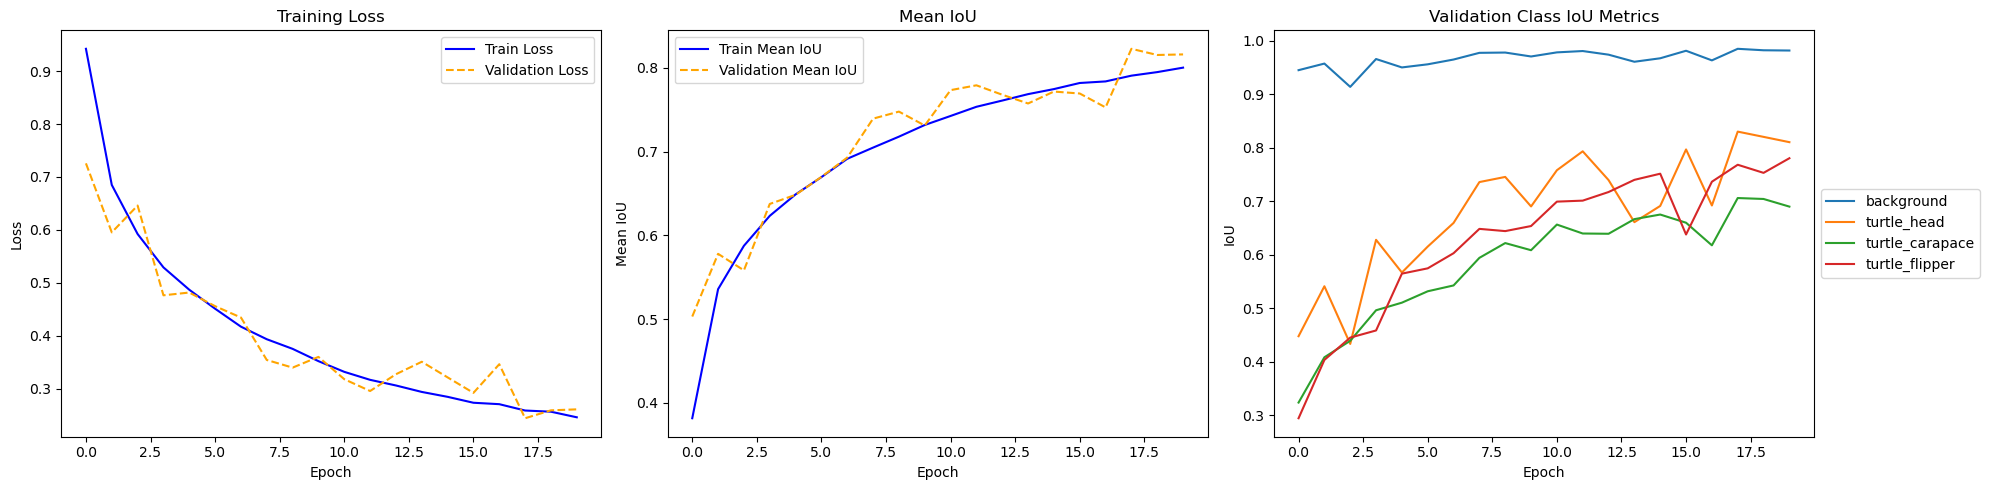


Loading best model for testing...

Evaluating on test set...


C:\Users\cando\AppData\Local\Temp\ipykernel_64900\1842764805.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoints/best_model.pth')



Test Results:
Test Mean IoU: 0.8214

Per-class IoU:
background: 0.9857
turtle_head: 0.8356
turtle_carapace: 0.7018
turtle_flipper: 0.7623

Generating final visualizations...

Visualizing test set results...


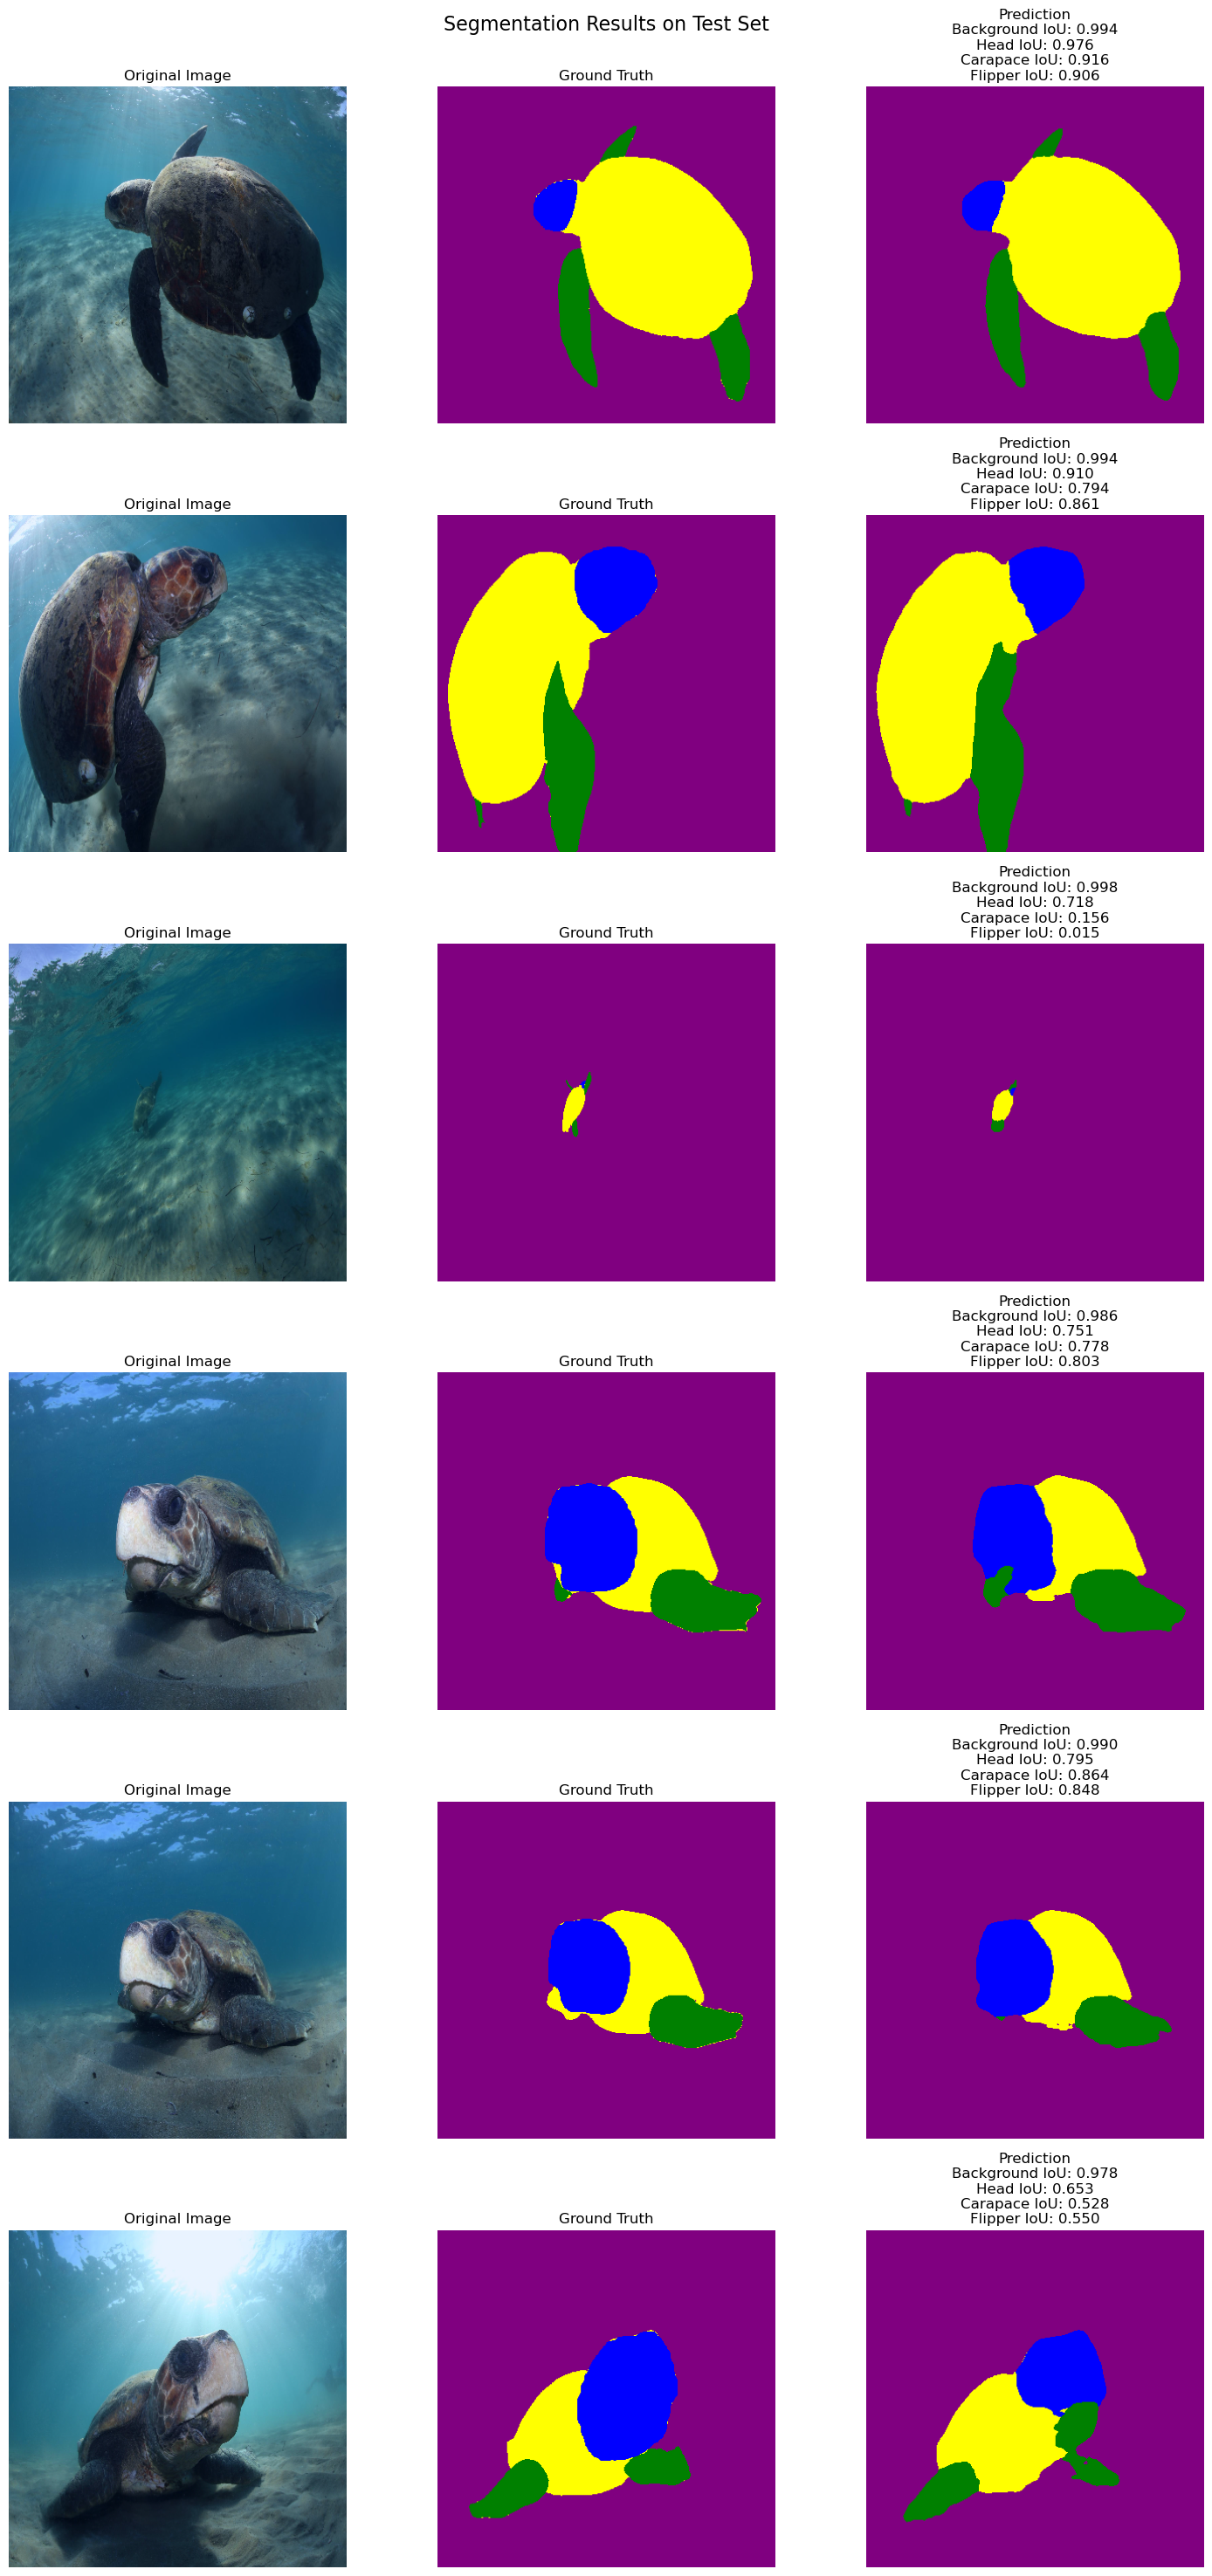


Per-image Segmentation Metrics:
   Background IoU  Head IoU  Carapace IoU  Flipper IoU  Mean IoU
0           0.994     0.976         0.916        0.906     0.948
1           0.994     0.910         0.794        0.861     0.890
2           0.998     0.718         0.156        0.015     0.472
3           0.986     0.751         0.778        0.803     0.829
4           0.990     0.795         0.864        0.848     0.874
5           0.978     0.653         0.528        0.550     0.677

Average Metrics:
Background IoU    0.990
Head IoU          0.800
Carapace IoU      0.673
Flipper IoU       0.664
Mean IoU          0.782
dtype: float64


In [5]:
# Plot training history
print("\nPlotting training history...")
plot_training_history(history)

# Load best model for testing
print("\nLoading best model for testing...")
checkpoint = torch.load('checkpoints/best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# Test evaluation
print("\nEvaluating on test set...")
test_metrics = evaluate_model(model, test_loader, criterion, device=device)  # Pass device

print("\nTest Results:")
print(f"Test Mean IoU: {test_metrics['mean_iou']:.4f}")
print("\nPer-class IoU:")
for i in range(NUM_CLASSES):
    print(f"{VOC_CLASSES[i]}: {test_metrics['class_iou'][i]:.4f}")

# Generate final visualizations
print("\nGenerating final visualizations...")
visualize_predictions(
    model,
    test_loader,
    num_samples=6,
    save_path='results/final_predictions.png',
    device=device 
)

print("\nVisualizing test set results...")
metrics_df = visualize_sample_predictions(model, test_loader, device=device)




Visualizing the best and the worst in the test set results...


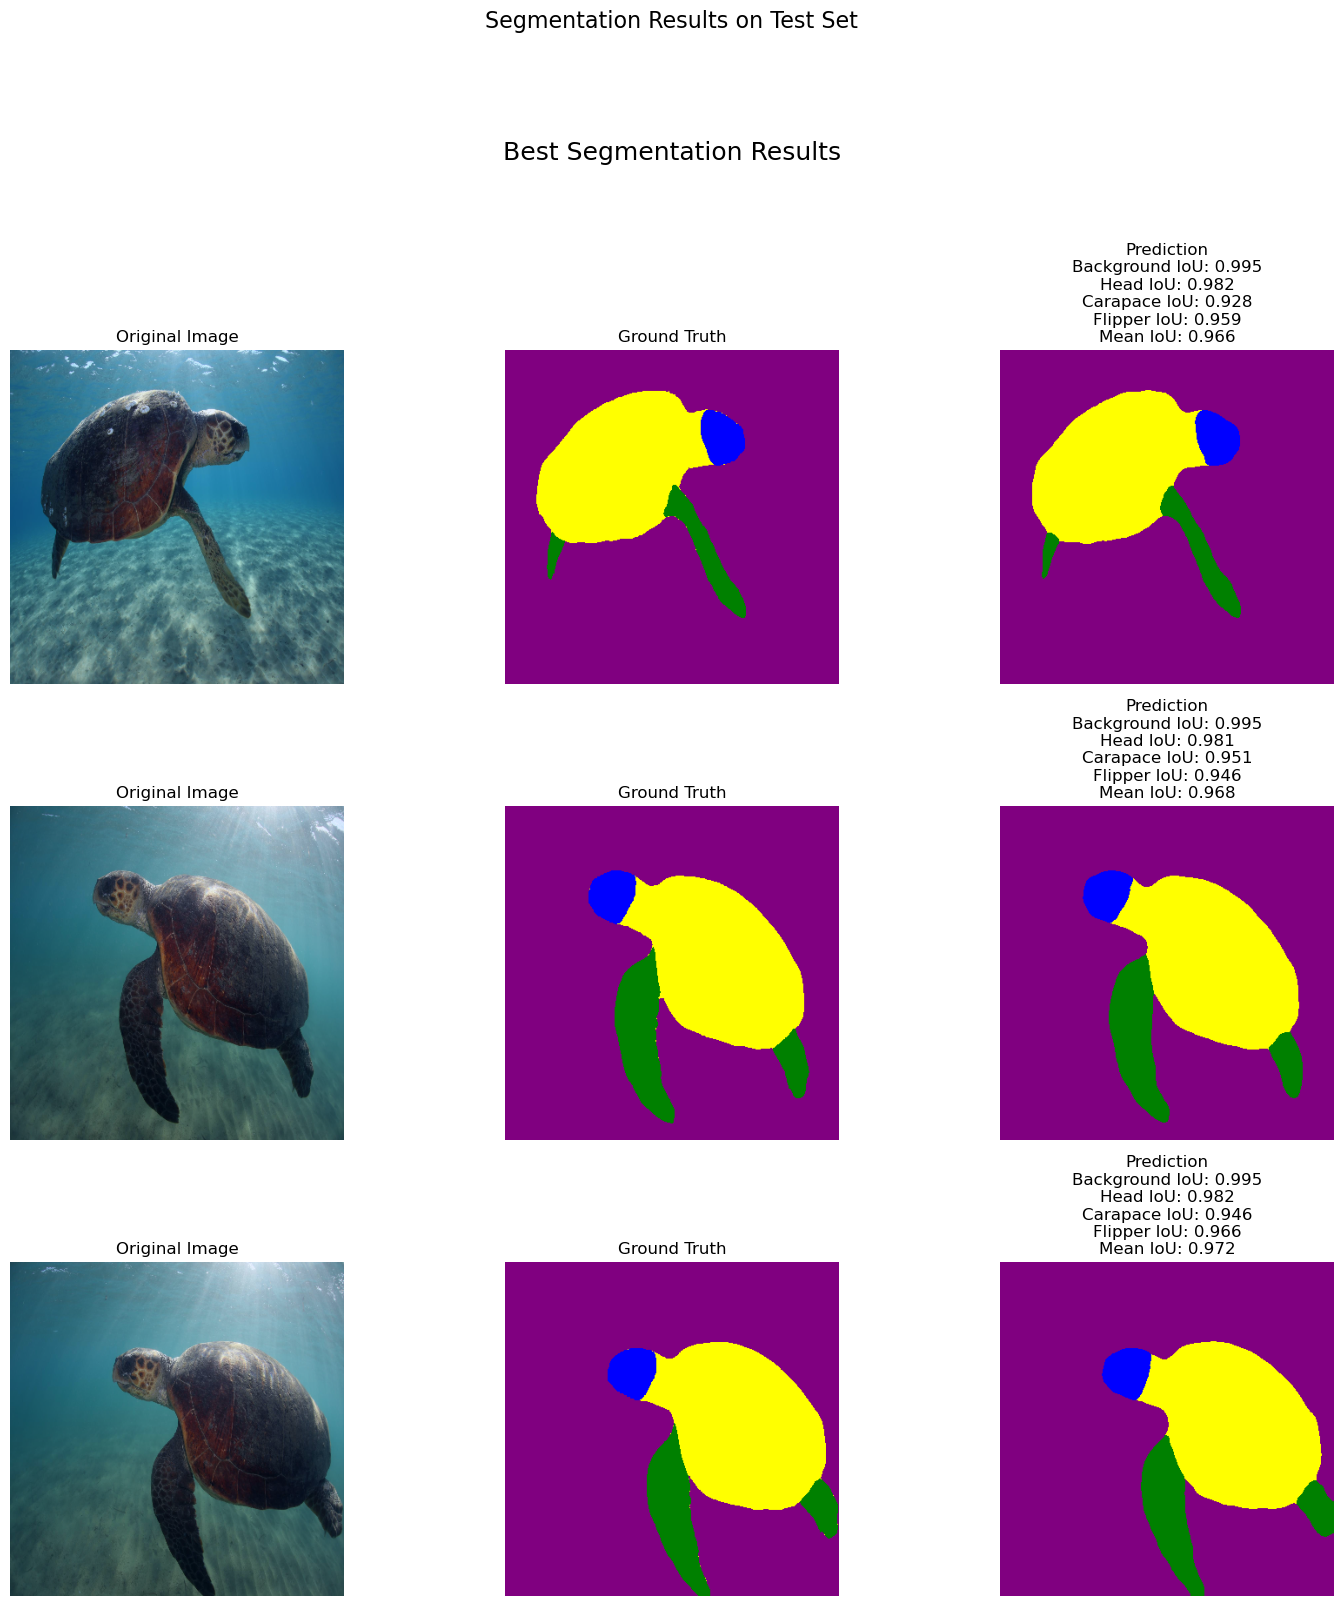

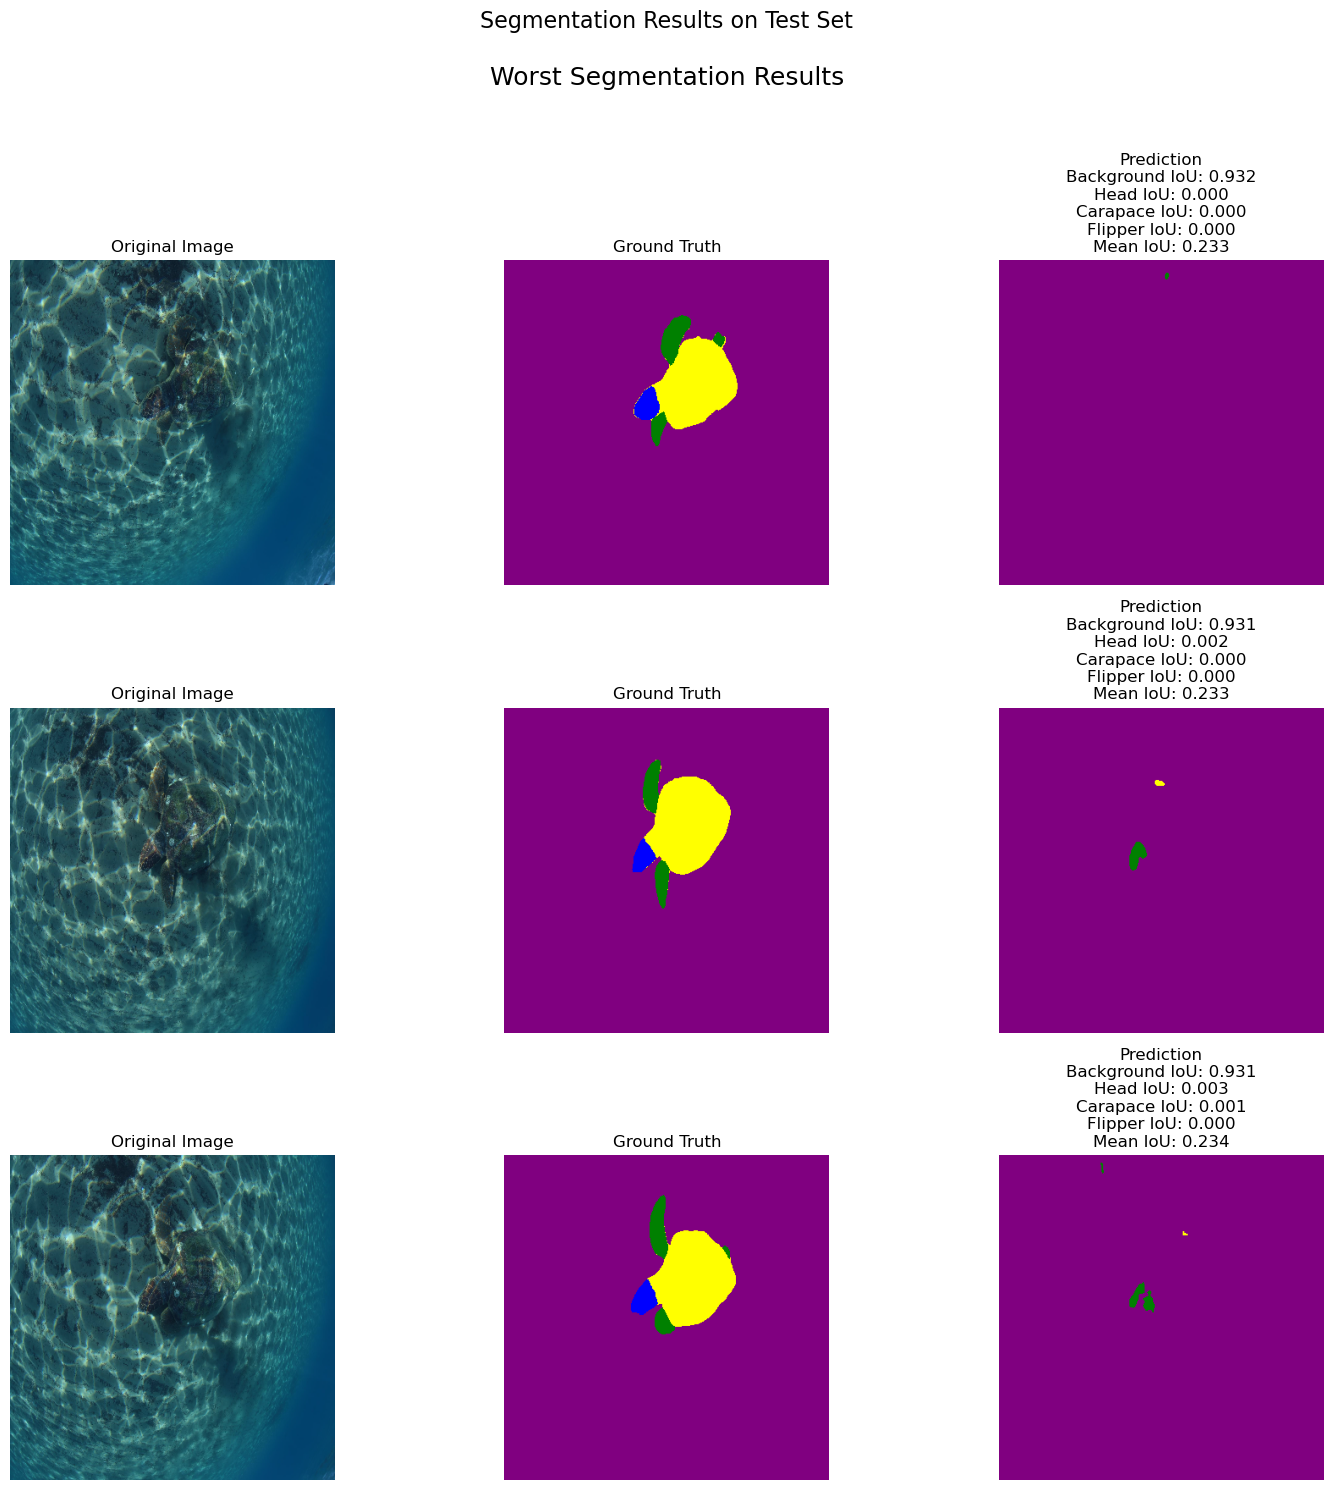


Training and evaluation completed successfully!


In [6]:
print("\nVisualizing the best and the worst in the test set results...")
visualize_best_predictions(model, test_loader, device=device)
visualize_worst_predictions(model, test_loader, device=device)
print("\nTraining and evaluation completed successfully!")